# Script to calculate mechanical properties of foams (efficiency of absorption $\eta(\epsilon)$, compression modulus, work of compression, plateau onset, etc) from a strain-stress curve ($\sigma$ as a function of $\epsilon$).

# The effficiency of absorption is calculated using the following expression:

#    $ \eta(\epsilon) = \frac{ \int_0^{\epsilon}{\sigma(\epsilon')d\epsilon'}}{{\sigma(\epsilon)}} $


For more infos, see the paper below (DOI: 10.1002/pol.20230704):
<span style="color: red;">Albuquerque, Meuchelböck, Ruckdäschel, J. Pol. Sci. 62 (2024) 1034-1043.</span>


## Input:

NOTE: your stress-strain curves must have epsilon (= strain) in percentage and sigma (= stress) in MPa units.

- txt file (space separated) or .csv file (comma separated, with or without a header) with two columns. First column = $\epsilon$, second column = $\sigma$ 
   
   OR
   
   
- excel file (.xls or .xlsx) with worksheets containing 2 columns (First column = $\epsilon$, second column = $\sigma$). You can provide the names of all worksheets you want to analyse or simply ask to analyse all available worksheets.

   OR
   

- folder with excel OR txt OR csv files, each file following the specification above.

TIP: Check the files and folders provided with this script (file 'inputs.zip') to learn about their format!

### Requirements: Install the libraries "pandas, matplotlib, scipy, numpy, xlrd and openpyxl"
- You can do it from inside the Jupyter Notebook by executing "!pip install numpy scipy pandas matplotlib xlrd openpyxl" (without double quotes!)


## Outputs:
   NOTE: In all outputs, epsilon has fractionary units (not percentage units!). A new folder (tagged with date and time) will be created and the different output files will be stored there:
  - Figure named "output_filename_sheetname.png" with the original stress-strain curve and the following calculated parameters: The efficiency of energy absorption $\eta(\epsilon)$ curve and $\eta_{max}$, work of compression ($W_{comp}$), epsilon where the densification starts ($\epsilon_{D}$), epsilon where the elastic region ends ($\epsilon_{pl}$) and corresponding sigma ($\sigma_{pl}$), Young's (or Compression) Modulus ($E_C$), the curve of $d\sigma/d\epsilon$ versus $\epsilon$ and the slope of the linear fit of the plateau region. The values of $\epsilon_{D}$ and $\epsilon_{pl}$ shown in the title of the upper subplot of the output figure, as well as shown inside the generated txt files did use the "zero-$\epsilon$" correction, which assumes that $\epsilon$ starts to be counted from the intersection of the tangent line at the elastic region (red line in the lower subplot of the output figure) and the horizontal axis (see below the parameter $\epsilon_0$ in the lower subplot of the output figure). Notice that $\epsilon_{pl}$ and $\sigma_{pl}$ (red circle in the lower subplot of the output figure) were plotted without this $\epsilon_0$ correction. $W_{comp}$ was calculated without this correction. 
  - A two-column .txt file named "eta_filename_sheetname.txt" with the $\eta(\epsilon)$ curve (first column = $\epsilon$, second column = efficiency or $\eta$).
  - If multiple files (from a given input folder) are treated, additional txt files with the different properties (one property per file) are generated. The files are named: Sigma_Plateau.txt, Slope_Plateau.txt, W_comp.txt, Epsilon_Densification.txt, Compression_Modulus.txt, Epsilon_Plateau.txt and Eta_max.txt. In each file, the average and standard deviation of all worksheets of a given input file are provided (in case of csv or txt files, the standard deviation is zero). A csv file named General_statistics.csv is also generated, where all averages and standard deviations of all calculated properties of all input files are compared.
  
## Online tutorial: [Click here to watch the video](https://mms.uni-bayreuth.de/Panopto/Pages/Viewer.aspx?id=2e1e92bd-504f-49f6-9d90-b068007446bf)
  
##### Script written by Rodrigo Q. de Albuquerque @11July2022 (experimental collaborators: Du lan, Johannes Meuchelboeck; theoretical collaborators: Jonathan Meierhofer), University of Bayreuth, Germany

# Libraries, Functions and General Parameters

In [16]:
################################################################
######################### LIBRARIES ############################
################################################################

import numpy as np
import pandas as pd
import glob, os, datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.integrate import simpson
from scipy.interpolate import CubicSpline
from scipy.stats import linregress as lr
import shutil, platform


################################################################
######################### FUNCTIONS ############################
################################################################

def property_reports(filename):
    """
    Reads the file with all properties (per excel file and per worksheet) and re-organize the data
    to generate separate txt files for each property (with mean and std of all sheets per excel file).
    
    Outputs:
    
    - Epsilon_Densification.txt  (or epsilon_D)
    - Epsilon_Plateau.txt  
    - Eta_max.txt  
    - Sigma_Plateau.txt  
    - Slope_Plateau.txt 
    - W_comp.txt  
    - Compression_Modulus.txt (or "compression modulus")
    """
    with open(filename) as f:
        lines = f.readlines()

    results = {}
    partial = []
    for line in lines:
        if 'File = ' in line:
            line_ = line.split()
            filename = line_[2]
            sheetname = line_[6][:-2]
            partial.append(filename)
            partial.append(sheetname)
        elif 'W_comp' in line:
            line_ = line.split()
            w_compr = float(line_[2])
            e_dens = float(line_[6][:-1])
            eta_max = float(line_[9])
            partial.append(w_compr)
            partial.append(e_dens)
            partial.append(eta_max)
        elif 'Compression_Modulus' in line:
            line_ = line.split()
            young = float(line_[2])
            e_plateau = float(line_[6][:-1])
            s_plateau = float(line_[9])
            partial.append(young)
            partial.append(e_plateau)
            partial.append(s_plateau)
        elif 'Slope_plateau' in line:
            line_ = line.split()
            slope_plateau = float(line_[2])
            partial.append(slope_plateau)

            key = partial[0] # filename is the key
            if partial[0] not in results:
                value = [partial[1:]] # [[sheet 1, w_comp1, etc]]
                results[key] = value
            else: # the first entry (for sheet 1) is already there
                partial_value = results[key] # nested list
                new_value = partial[1:]
                partial_value.append(new_value)
                results[key] = partial_value
            partial = []

    stats = []
    for key in results:

        sheets = results[key]

        w = [sheet[1] for sheet in sheets]
        w_avg = np.mean(w)
        w_std = np.std(w)

        edens = [sheet[2] for sheet in sheets]
        edens_avg = np.mean(edens)
        edens_std = np.std(edens)

        etamax = [sheet[3] for sheet in sheets]
        etamax_avg = np.mean(etamax)
        etamax_std = np.std(etamax)

        young = [sheet[4] for sheet in sheets]
        young_avg = np.mean(young)
        young_std = np.std(young)

        eplat = [sheet[5] for sheet in sheets]
        eplat_avg = np.mean(eplat)
        eplat_std = np.std(eplat)

        splat = [sheet[6] for sheet in sheets]
        splat_avg = np.mean(splat)
        splat_std = np.std(splat)

        slope = [sheet[7] for sheet in sheets]
        slope_avg = np.mean(slope)
        slope_std = np.std(slope)

        stats.append([key, w_avg, w_std, edens_avg, edens_std, etamax_avg, etamax_std, young_avg, young_std, eplat_avg, eplat_std, splat_avg, splat_std, slope_avg, slope_std])

    ############# generate different files #################
    
    # check current folder
    if input_type == 'folder':
        complement = f'../{tag}/'
    else:
        complement = f'{tag}/'
    
    # W_Compression: 
    k, prop, unit = 1, 'W_comp', 'W/m^3'
    line1 = [[prop+'_MEAN',prop+'_STD'] for file in stats]
    line1 = [item for sublist in line1 for item in sublist]
    line1 = ' '.join(line1) + '\n'
    line2 = [[file[0], file[0]] for file in stats]
    line2 = [file for sublist in line2 for file in sublist]
    line2 = ' '.join(line2) + '\n'
    line3 = [[unit,unit] for file in stats]
    line3 = [item for sublist in line3 for item in sublist]
    line3 = ' '.join(line3) + '\n'
    line4 = [[file[k],file[k+1]] for file in stats]
    line4 = [str(item) for sublist in line4 for item in sublist]
    line4 = ' '.join(line4) + '\n'
    mylines = line1 + line3 + line2 + line4
    with open(f'{complement}{prop}.txt', 'w') as f:
        f.write(mylines)

    # Epsilon_Densification: 
    k, prop, unit = 3, 'Epsilon_Densification', 'Unitless'
    line1 = [[prop+'_MEAN',prop+'_STD'] for file in stats]
    line1 = [item for sublist in line1 for item in sublist]
    line1 = ' '.join(line1) + '\n'
    line2 = [[file[0], file[0]] for file in stats]
    line2 = [file for sublist in line2 for file in sublist]
    line2 = ' '.join(line2) + '\n'
    line3 = [[unit,unit] for file in stats]
    line3 = [item for sublist in line3 for item in sublist]
    line3 = ' '.join(line3) + '\n'
    line4 = [[file[k],file[k+1]] for file in stats]
    line4 = [str(item) for sublist in line4 for item in sublist]
    line4 = ' '.join(line4) + '\n'
    mylines = line1 + line3 + line2 + line4
    with open(f'{complement}{prop}.txt', 'w') as f:
        f.write(mylines)

    # Eta_max
    k, prop, unit = 5, 'Eta_max', '%'
    line1 = [[prop+'_MEAN',prop+'_STD'] for file in stats]
    line1 = [item for sublist in line1 for item in sublist]
    line1 = ' '.join(line1) + '\n'
    line2 = [[file[0], file[0]] for file in stats]
    line2 = [file for sublist in line2 for file in sublist]
    line2 = ' '.join(line2) + '\n'
    line3 = [[unit,unit] for file in stats]
    line3 = [item for sublist in line3 for item in sublist]
    line3 = ' '.join(line3) + '\n'
    line4 = [[file[k],file[k+1]] for file in stats]
    line4 = [str(item) for sublist in line4 for item in sublist]
    line4 = ' '.join(line4) + '\n'
    mylines = line1 + line3 + line2 + line4
    with open(f'{complement}{prop}.txt', 'w') as f:
        f.write(mylines)

    # Young's (or compression) Modulus
    k, prop, unit = 7, 'Compression_Modulus', 'MPa'
    line1 = [[prop+'_MEAN',prop+'_STD'] for file in stats]
    line1 = [item for sublist in line1 for item in sublist]
    line1 = ' '.join(line1) + '\n'
    line2 = [[file[0], file[0]] for file in stats]
    line2 = [file for sublist in line2 for file in sublist]
    line2 = ' '.join(line2) + '\n'
    line3 = [[unit,unit] for file in stats]
    line3 = [item for sublist in line3 for item in sublist]
    line3 = ' '.join(line3) + '\n'
    line4 = [[file[k],file[k+1]] for file in stats]
    line4 = [str(item) for sublist in line4 for item in sublist]
    line4 = ' '.join(line4) + '\n'
    mylines = line1 + line3 + line2 + line4
    with open(f'{complement}{prop}.txt', 'w') as f:
        f.write(mylines)

    # Epsilon_Plateau
    k, prop, unit = 9, 'Epsilon_Plateau', 'Unitless'
    line1 = [[prop+'_MEAN',prop+'_STD'] for file in stats]
    line1 = [item for sublist in line1 for item in sublist]
    line1 = ' '.join(line1) + '\n'
    line2 = [[file[0], file[0]] for file in stats]
    line2 = [file for sublist in line2 for file in sublist]
    line2 = ' '.join(line2) + '\n'
    line3 = [[unit,unit] for file in stats]
    line3 = [item for sublist in line3 for item in sublist]
    line3 = ' '.join(line3) + '\n'
    line4 = [[file[k],file[k+1]] for file in stats]
    line4 = [str(item) for sublist in line4 for item in sublist]
    line4 = ' '.join(line4) + '\n'
    mylines = line1 + line3 + line2 + line4
    with open(f'{complement}{prop}.txt', 'w') as f:
        f.write(mylines)

    # Sigma_Plateau
    k, prop, unit = 11, 'Sigma_Plateau', 'MPa'
    line1 = [[prop+'_MEAN',prop+'_STD'] for file in stats]
    line1 = [item for sublist in line1 for item in sublist]
    line1 = ' '.join(line1) + '\n'
    line2 = [[file[0], file[0]] for file in stats]
    line2 = [file for sublist in line2 for file in sublist]
    line2 = ' '.join(line2) + '\n'
    line3 = [[unit,unit] for file in stats]
    line3 = [item for sublist in line3 for item in sublist]
    line3 = ' '.join(line3) + '\n'
    line4 = [[file[k],file[k+1]] for file in stats]
    line4 = [str(item) for sublist in line4 for item in sublist]
    line4 = ' '.join(line4) + '\n'
    mylines = line1 + line3 + line2 + line4
    with open(f'{complement}{prop}.txt', 'w') as f:
        f.write(mylines)

    # Slope_Plateau
    k, prop, unit = 13, 'Slope_Plateau', 'MPa'
    line1 = [[prop+'_MEAN',prop+'_STD'] for file in stats]
    line1 = [item for sublist in line1 for item in sublist]
    line1 = ' '.join(line1) + '\n'
    line2 = [[file[0], file[0]] for file in stats]
    line2 = [file for sublist in line2 for file in sublist]
    line2 = ' '.join(line2) + '\n'
    line3 = [[unit,unit] for file in stats]
    line3 = [item for sublist in line3 for item in sublist]
    line3 = ' '.join(line3) + '\n'
    line4 = [[file[k],file[k+1]] for file in stats]
    line4 = [str(item) for sublist in line4 for item in sublist]
    line4 = ' '.join(line4) + '\n'
    mylines = line1 + line3 + line2 + line4
    with open(f'{complement}{prop}.txt', 'w') as f:
        f.write(mylines)
        
    # second format of the final_report_of_properties suggested:
    with open(f'{complement}General_statistics.csv', 'w') as f:
        line1 = 'Series Name, W_comp (MEAN), W_comp (STD), '
        line1 += 'Epsilon_Densification (MEAN), Epsilon_Densification (STD), '
        line1 += 'Eta_max (MEAN), Eta_max (STD), '
        line1 += "Compression_Modulus (MEAN), Compression_Modulus (STD), "
        line1 += 'Epsilon_Plateau (MEAN), Epsilon_Plateau (STD), '
        line1 += 'Sigma_Plateau (MEAN), Sigma_Plateau (STD), '
        line1 += 'Slope_Plateau (MEAN), Slope_Plateau (STD)\n'
        f.write(line1)
        line2 = ' , J/M^3, J/M^3, Unitless, Unitless, %, %, MPa, MPa, Unitless, Unitless, MPa, MPa, MPa, MPa\n'
        f.write(line2)
        for line in stats:
            line = [str(item) for item in line]
            line = ','.join(line) + '\n'
            f.write(line)
        

def organize_folders(filename):
    '''
    Organize folders for outputs
    '''
    global tag
    timenow = datetime.datetime.now()
    tag = f"{filename}__" + timenow.strftime("%Y%m%d_%H%M%S")
    tag = tag.replace('.xlsx','')
    tag = tag.replace('.xls','')
    tag = tag.replace('.csv','')
    tag = tag.replace('.txt','')
    
    if not os.path.isdir(tag):
        os.system(f"mkdir {tag}")
    else:
        tag = tag + "_" + tag
        os.system(f"mkdir {tag}")


def curate(data):
    """
    Eliminate negative values of sigma and retain only the first curve/signal (i.e., keep only increasing values
    of X and Y). 'data' = 2D array with epsilon and sigma as first and second columns, respectively.
    Also, keep epsilon in the fractionary range (not in percentage) and interpolate the points if needed.
    """
    data2 = np.array(data, dtype = np.float64)
    
    # select positive values
    data3 = data2[data2[:,0] >= 0]
    data4 = data3[data3[:,1] >= 0]
    
    # select first cycle (threshold = 5%)
    x_max = np.max(data4[:,0])
    curated = []
    for row in data4:
        x,y = row
        deviation = abs(100*(x_max - x)/x_max) # percentual distance from x_max
        if deviation >= 5:
            curated.append([x,y])
        else:
            break
    
    # remove repeated non-increasing x values
    x0, y0 = curated[0]
    curated2 = [[x0,y0]] # first element stays
    current_max_x = x0
    for i, row in enumerate(curated):
        if i < len(curated) - 1:
            x1 = row[0]
            x2, y2 = curated[i+1]
            if x2 > x1 and x2 > current_max_x:
                current_max_x = x2
                curated2.append([x2, y2])
    data5 = np.array(curated2).reshape(-1,2)
    
    # epsilon should be in the range [0,1]
    if np.max(data5[:,0]) > 1.1: # epsilon is in the range [0,100%]
        data5[:,0] = data5[:,0]/100
    
    # interpolate data? if yes, use 1000 points (= default)
    if data5.shape[0] < 1000:
        xs = np.linspace(data5[0,0], data5[-1,0], num = 1000)
        cs = CubicSpline(data5[:,0], data5[:,1]) # generate the interpolation object cs
        ys = cs(xs) # apply the interpolation on the interpolated x values
        data_interpolated = np.c_[xs.reshape(-1,1), ys.reshape(-1,1)]
        data5 = data_interpolated
    
    return data5
    

def get_eta(data):
    '''
    Calculate efficiency eta (see equation above) as a function of strain, as well as epsilon at eta_max 
    (= epsilon_max) and sigma at epsilon_max (=sigma_max). 'data' is a 2D array with epsilon and sigma 
    as first and second columns, respectively.
    '''
   
    eta = []
    for i in range(data[:,0].size-1):
        epsilon = data[i+1,0] # current x value
        sigma = data[i+1,1] # current y value   
        data_ = data[:i+1] # all points up to (epsilon, sigma)
        x, y = data_[:i+1,0], data_[:i+1,1]
        numerator = simpson(y, x=x)
        denominator = sigma
    
        if numerator != 0 and denominator != 0:
            eta_value = (numerator / denominator) * 100 #  result in percentage
            eta.append([epsilon, eta_value])    

    eta = np.array(eta).reshape(-1,2)
    max_index = np.argmax(eta[:,1])
    epsilon_max = eta[max_index,0]
    sigma_max = eta[max_index,1]
    
    return eta, epsilon_max, sigma_max


def results_new(filename, sheetname, data, data_new, eta, epsilon_max, sigma_max, threshold_for_calculating_work, show_plots_below, first_derivative, young, plateau, xmax, foldername = None):
    '''
    Plot the final curves (eta versus epsilon + epsilon x sigma + first derivative), and save
    the eta curve (as ASCII, .txt file) and the plot (as .png) using the names:
    
    eta_filename_sheetname.txt
    eta_filename_sheetname.png
    '''
    global filename_results
    
    ##########################
    # SUB-FUNCTIONS ##########

    def y_emodul(x):
        '''
        Real equation of the line used as tangent of the experimental curve to calculate E-Modulus (or the young modulus).
        y = ax + b
        a = Young's Modulus
        b = Linear coefficient determined above
        '''
        lin_coeff = y_tangent - young*x_tangent
        y = young*x + lin_coeff
        return y

    def y_emodul_shift(x):
        '''
        Equation of the tangent (E-Module, see function y_modul) shifted/translated by +0.002 (or 0.2%) in the
        x axis and having the same slope
        '''
        lin_coeff = y_tangent - young*(x_tangent + 0.002)
        y_shift = x*young + lin_coeff
        return y_shift
    
    def adjust(axis_thickness=2.2):
        """
        Make thicker axis lines (add this function at the end of the plot or subplot)
        """
        ax = plt.gca()
        # Set the linewidth of the frame
        ax.spines['top'].set_linewidth(axis_thickness)    # Top frame
        ax.spines['bottom'].set_linewidth(axis_thickness) # Bottom frame
        ax.spines['left'].set_linewidth(axis_thickness)   # Left frame
        ax.spines['right'].set_linewidth(axis_thickness)  # Right frame
    
    
    ######## END OF FUNCTIONS #######
    
    x_plateau, y_plateau = plateau

    
    # Correct epsilon_D and epsilon_pl using epsilon_zero
    x_plateau -= epsilon_zero # this is epsilon_pl in the upper plot
    epsilon_max -= epsilon_zero # this is epsilon_D in the upper plot



    
    try: # if input file is a txt file, this raises an error
        sheetname = sheetname.replace(' ','')
    except:
        sheetname = 'TXT-file'
    
    filename = filename.replace(' ','')
    if filename[-1].lower() == 'x':
        dump = -5
    else:
        dump = -4
    if input_type == 'folder': # we are currently inside another folder (there is no tag sub-folder here!)
        np.savetxt(f'../{tag}/eta_{filename[:dump]}_{sheetname}.txt', eta)
    else: # we are in the main folder, save directly to results folder 'tag'
        np.savetxt(f'{tag}/eta_{filename[:dump]}_{sheetname}.txt', eta)
        
    eta_max = np.max(eta[:,1])
    eta_max_string = "$\eta_{max}$"
        
    plt.figure(figsize=(10,14))
    
    #########################
    plt.subplot(2,1,1)
    #########################
    
    plt.plot(data_new[:,0], data_new[:,1],'-b', lw=2, label = 'Input', zorder=140) # Input funtion for the first plot uses the corrected dataset data_new
    ymax = np.max(data[:,1])
    
    # 1.a) first derivative of the sigma x epsilon curve
    c = first_derivative
    c = c[c[:,0] < epsilon_max+epsilon_zero] #based on original data set, so epsilon_zero is added
    dydx_norm = c.copy()
    dydx_norm[:,1] = (3*ymax/4) * (dydx_norm[:,1] / np.max(dydx_norm[:,1]))
    plt.plot(dydx_norm[:,0]-epsilon_zero, dydx_norm[:,1], '-', color = 'gray', label = r'$d\sigma/d\epsilon$ (scaled)' ) # epsilon_zero is substracted to plot correctly with the original input data!
    
    

    
    # LABELS
    plt.xlabel(f'$\epsilon - \epsilon_0$ ', fontsize=24)
    plt.ylabel(f'$\sigma$ / {unit_sigma}', fontsize=24)

    # add Wc to the plot
    position_x = epsilon_max / 2
    for i, item in enumerate(data[:,0]):
        if item > position_x:
            position_x = item
            index_f = i
            break
    position_y = data[index_f, 1] / 2
    plt.annotate(r'$W_{comp}$', (position_x, position_y), size = 14, zorder = 110)

    # gray shaded area under the blue curve
    # select data with epsilon <= threshold_for_ploting_area
    if threshold_for_calculating_work == 'auto':
        threshold_for_calculating_work = epsilon_max
    shade_points = []
    for point in data_new:
        if lowerlimit_epsilon_pl.lower() == 'true':
            if x_plateau <= point[0] <= threshold_for_calculating_work:
                shade_points.append([point[0], point[1]])
        else:
            if 0 <= point[0] <= threshold_for_calculating_work:
                shade_points.append([point[0], point[1]])
           
    shade_points = np.array(shade_points).reshape(-1,2)

    area_shade = simpson(shade_points[:,1], x=shade_points[:,0]) # integral(y,x)
    plt.fill_between(shade_points[:,0], shade_points[:,1], color='lightblue', zorder=2, alpha=0.8)
    
    # Linear regression of the plateau:
    slope_plat, intercept_plat = slope_plateau(data_new, x_plateau, epsilon_max)
    x_plat = np.linspace(x_plateau, epsilon_max, 100)
    y_plat = slope_plat * x_plat + intercept_plat
    plt.plot(x_plat, y_plat, '-', color = "darkorange", lw = 3.5, zorder = 150, label=r'Linear fit (plateau)')    
    
    plt.title(f"{filename[:dump]} ({sheetname})\n" + r"$W_{comp}$ = " + f"{round(area_shade,4)} $J/m^3$  |  " + r"$\epsilon_D$ = " + f"{round(epsilon_max,4)}  |  {eta_max_string} = {round(eta_max,2)} %\nCompression Modulus = {young:.2f} MPa  |  " + r"$\epsilon_{pl}$ = " + f"{x_plateau:.4f}\n" + r"$\sigma_{pl}$ = " + f"{y_plateau:.4f} MPa  |  " + r"Slope (Fit$_{plateau}$) = " + f"{slope_plat:.2f} MPa\n\n", fontsize = 15)
 
    # Annotation: REGIONS:
    plt.annotate('ELASTIC', xy = (0, 1.02), xycoords=("axes fraction","axes fraction"), size = 15, zorder = 110)
    plt.annotate('PLATEAU', xy = (0.42, 1.02), xycoords=("axes fraction","axes fraction"), size = 15, zorder = 110)
    plt.annotate('DENSIFICATION', xy = (0.81, 1.02), xycoords=("axes fraction","axes fraction"), size = 15, zorder = 110)
    
    plt.plot([x_plateau, x_plateau], [0, 3*ymax/4], '--', color='green', label = r'$\epsilon_{pl}$', zorder=140)
    plt.ylim(0,ymax) 
    
    # 2) Efficiency
    eta_norm = eta.copy()
    eta_norm[:,1] = (3*ymax/4) * (eta_norm[:,1] / np.max(eta_norm[:,1]))
    plt.plot(eta_norm[:,0]-epsilon_zero, eta_norm[:,1], '-r', label = r'Efficiency ($\eta$, scaled)', zorder=1) # epsilon_zero is substracted to plot correctly with the original input data!
    plt.plot([epsilon_max, epsilon_max],[0, 3*ymax/4], '--k', label = r'$\epsilon_D$', zorder=140)

    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(frameon=False, loc="upper left", ncol=3, fontsize = 14)

    adjust() # thicker axis lines

    #########################
    plt.subplot(2,1,2)
    #########################
    plt.plot(data[:,0], data[:,1], '-bo', lw = 2, label = "Input")
    
    for i, point in enumerate(data):
        xexp = point[0]
        yexp = point[1]
        if xexp > xmax:
            point = data[i-1]
            x_tangent = point[0]
            y_tangent = point[1]
            break
    plt.plot([xmax, xmax], [0, y_plateau*1.05], '--', color='purple', label = r'$\epsilon_{max} \equiv \epsilon~at~(d\sigma/d\epsilon)_{max}$')
    
    # below, epsilon_zero re-added to cope with original input data
    plt.plot([0, (x_plateau+epsilon_zero) * 1.05], [y_emodul(0), y_emodul((x_plateau+epsilon_zero )* 1.05)],'-r', label = r'Tangent at $\epsilon_{max}$ (slope = $E_C$)') 
    
    xshift = np.linspace(0, (x_plateau+epsilon_zero) * 1.05, 100) # epsilon_zero re-added to cope with original input data
    yshift = y_emodul_shift(xshift)
    plt.plot(xshift, yshift, '-g', label = 'Tangent at $\epsilon_{max}$ + 0.002')
    
    # to plot this point correctly in the original input data, we need to add again the epsilon_zero!
    plt.plot(x_plateau+epsilon_zero, y_plateau, 'ro', ms = 10, label = r"Plateau onset ($\epsilon_{pl}$, $\sigma_{pl}$):")

    plt.xlim(0, (x_plateau + epsilon_zero) * 1.05) # epsilon_zero was re-added to plot correctly with the original input data!
    plt.ylim(0, y_plateau * 1.05)
    
    # Add the zero-epsilon
    total_height = y_plateau * 1.05
    plt.plot(epsilon_zero, total_height * 0.01, 'kv', ms = 10, label = r"$\epsilon_0$ = " + f'{epsilon_zero:.4f}', zorder=1000)

    plt.title(f"{filename[:dump]} ({sheetname})\nAnalysis of the linear elastic region", fontsize=15)
    plt.xlabel(f'$\epsilon$', fontsize=24)
    plt.ylabel(f'$\sigma$ / {unit_sigma}', fontsize=24)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(frameon = False, loc = "upper left", fontsize = 14)
    
    plt.tight_layout(pad = 2)
    
    adjust() # thicker axis lines
    
    if input_type == 'folder':
        plt.savefig(f'../{tag}/output_{filename[:dump]}_{sheetname}.png', dpi=600)
    else:
        plt.savefig(f'{tag}/output_{filename[:dump]}_{sheetname}.png', dpi=600)
    
    ##### SHOW RESULTS IN THE SCREEN
    if show_plots_below.lower() == 'no':
        plt.close()
        BOLD = '\033[1m'
        END = '\033[0m'
        fname = BOLD + f"File = {filename[:dump]} (sheet name = {sheetname})" + END
        eta_m = f"eta_max = {eta_max:.2f} %"
        wc = f"W_comp = {round(area_shade,2)} J/m^3"
        ed = f"epsilon_D = {round(epsilon_max,3)}"
        ym = f"Compression_Modulus = {young:.2f} MPa"
        ep = f"epsilon_plateau = {x_plateau:.3f}"
        sp = f"sigma_plateau = {y_plateau:.2f} MPa"
        spl = f"  Slope_plateau(fit) = {slope_plat:.2f} MPa"
        print(f'{fname}:\n  {wc}, {ed}, {eta_m}\n  {ym}, {ep}, {sp}\n{spl}\n\n################################\n')
    else:
        plt.show()
    

    ############### SAVE RESULTS IN THE FILE ########################
    filename_results = tag + '/' + foldername + '.txt'
    filename_results = filename_results.replace('.xlsx','')
    filename_results = filename_results.replace('.xls','')
    
    if input_type == 'folder': # save all files to the correct results tag subfolder (it is not in the current folder!)
        filename_results = '../' + filename_results
    
    if not os.path.isfile(filename_results):
        with open(filename_results,'w') as f:
            f.write("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n")
            f.write(f"Results of the Stress-Strain analysis for all stress-strain curves in '{foldername}'\n")
            f.write("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n")
            plt.close()
            fname = f"File = {filename[:dump]} (sheet name = {sheetname})"
            eta_m = f"eta_max = {eta_max:.2f} %"
            wc = f"W_comp = {round(area_shade,2)} J/m^3"
            ed = f"epsilon_D = {round(epsilon_max,3)}"
            ym = f"Compression_Modulus = {young:.2f} MPa"
            ep = f"epsilon_plateau = {x_plateau:.3f}"
            sp = f"sigma_plateau = {y_plateau:.2f} MPa"
            spl = f"  Slope_plateau(fit) = {slope_plat:.2f} MPa"
            f.write(f'{fname}:\n  {wc}, {ed}, {eta_m}\n  {ym}, {ep}, {sp}\n{spl}\n\n################################\n\n')
    else:
        with open(filename_results, 'a') as f:
            plt.close()
            fname = f"File = {filename[:dump]} (sheet name = {sheetname})"
            eta_m = f"eta_max = {eta_max:.2f} %"
            wc = f"W_comp = {round(area_shade,2)} J/m^3"
            ed = f"epsilon_D = {round(epsilon_max,3)}"
            ym = f"Compression_Modulus = {young:.2f} MPa"
            ep = f"epsilon_plateau = {x_plateau:.3f}"
            sp = f"sigma_plateau = {y_plateau:.2f} MPa"
            spl = f"  Slope_plateau(fit) = {slope_plat:.2f} MPa"
            f.write(f'{fname}:\n  {wc}, {ed}, {eta_m}\n  {ym}, {ep}, {sp}\n{spl}\n\n################################\n\n')

    # Re-organize all saved data to produce txt files with aggregated properties per excel input
    property_reports(filename_results)
    
    
def get_derivative(x, y, npoints):
    '''
    Calculate the numerical derivative dy/dx given x and y (= 1D arrays). The experimental points provided are 
    first interpolated with 'npoints' and then the derivative of the latter is carried out.
    Output: 2D array: x_mean (first column), dydx (second column) 
    '''  
    xs = np.linspace(x[0], x[-1], num = npoints)
    cs = CubicSpline(x, y) # generate the interpolation object cs
    ys = cs(xs) # apply the interpolation on the interpolated x values
    interpolation = np.c_[xs.reshape(-1,1), ys.reshape(-1,1)]
    
    # here, (xs, ys) is the interpolated curve
    dydx = np.diff(ys)/np.diff(xs) # derivative of the interpolated curve
    # calculating xmean
    xmean = []
    for i in range(xs.shape[0] - 1):
        media = (xs[i] + xs[i+1])/2
        xmean.append(media)
    xmean = np.array(xmean).reshape(-1,1)
    dydx = dydx.reshape(-1,1)
    derivative_of_interpolation = np.c_[xmean, dydx]
    
    return derivative_of_interpolation, interpolation 
    
    
    
def get_youngs_modulus(first_derivative, epsilon_max, tolerance):
    '''
    Extract the first peak (on the left, low strain side) of the first derivative of the stress-strain curve
    first_derivative = 2D array (x versus derivative)
    Returns: Xmax and Young's Modulus
    '''
    #tolerance = 4 # number of times y-value decreases after finding the peak
    c = first_derivative
    c = c[c[:,0] < epsilon_max] # Take only the left side of the derivative (strain < epsilon_max)
        
    # if y value decreased "tolerance" succesive times, we found a peak!
    indices_decrease = [] # indices where y value decreased (must be successive to characterize passed peak)
    youngs_modulus = 0 # c[0,1]
    for i in range(c.shape[0]-1):
        y = c[i+1, 1]
        x = c[i+1, 0]
        if y >= youngs_modulus: # climbing the peak from left to right
            xmax = x
            youngs_modulus = y
            index_max = i+1
        else: # value decreased! (going down the peak from left to right)
            indices_decrease.append(i+1)
            
            # keep indices > index_max
            indices_decrease = [k for k in indices_decrease if k > index_max]
            if len(indices_decrease) == tolerance:
                break
            
    return xmax, youngs_modulus    
    

    
def get_plateau(data, young, xmax):
    '''
    Find the cross point between y_emodul_shift (the E-modul tangent shifted by +0.2%) and the experimental sigma x
    epsilon curve. 
    Return: epsilon_plateau (or x_plateau), sigma_plateau (or y_plateau)
    '''
    # tangent point on the original curve for the E-Modulus: (x_tangent, y_tangent)
    for i, point in enumerate(data):
        xexp = point[0]
        yexp = point[1]
        if xexp > xmax:
            point = data[i-1]
            x_tangent = point[0]
            y_tangent = point[1]
            break
    
    def y_emodul_shift(x, young, x_tangent, y_tangent):
        '''
        Equation of the tangent (E-Module, see function y_modul) shifted/translated by +0.002 (or 0.2%) in the
        x axis and having the same slope
        '''
        lin_coeff = y_tangent - young*(x_tangent + 0.002)
        y_shift = x*young + lin_coeff
        return y_shift
        
    for i, point in enumerate(data):
        x_exp = point[0]
        y_exp = point[1]
        y_theo = y_emodul_shift(x_exp, young, x_tangent, y_tangent)
        if y_exp < y_theo and x_exp > xmax:
            point = data[i-1]
            x_plateau = point[0]
            y_plateau = point[1]
            break
            
    return x_plateau, y_plateau
    

    
def slope_plateau(data, x_plateau, epsilon_max):
    '''
    Calculate the slope of the best line passing through the plateau region
    Returns: The slope and linear coefficient (intercept) of the fitted line
    '''
    data_ = data[data[:,0] >= x_plateau]
    data_plateau = data_[data_[:,0] <= epsilon_max]
    x = data_plateau[:,0]
    y = data_plateau[:,1]    
    result_fit = lr(x,y)
    
    return result_fit.slope, result_fit.intercept
    
    
    
def main(fileORfolder_name, sheet_names, threshold_for_calculating_work, show_plots_below, tolerance):
    '''
    Load the excel file and initialize it, returning a 2D array (= epsilon x sigma)

    inputs:
      fileORfolder_name: filename or foldername (string)
      sheet_names: list of strings with the sheet names needed in the calculation. To get all available
                sheets, use sheet_names = "all"
    '''
    global input_type, pc, filename_results, epsilon_zero
    
    ############# PARAMETERS ############
    npoints = 100
    # Number of points used in the cubic spline interpolation, which is used in the calculation 
    # of the Young's Modulus. Change/increase this parameter if the geometric solution of the Young's 
    # Modulus shown in the plots are not satisfactory (e.g., the first derivative plotted has no clearly
    # identifiable single peak).
    ###################################
    
    pc = platform.platform().split('-')[0].lower() # 'linux', 'windows', 'somethingelse'(mac)
    
    organize_folders(fileORfolder_name) # create a folder to place the results (folder path = {tag}/)
    
    # folder or file?
    term = fileORfolder_name[-5:].lower()
    if '.xls' in term or '.xlsx' in term:
        input_type = 'excel file'
    elif '.txt' in term:
        input_type = 'txt file'
    elif '.csv' in term:
        input_type = 'csv file'
    else:
        input_type = 'folder' # In this case, apply the same if conditions above once 
                              # more and ask the name of the 'tab' (if applied)
    
    if input_type == 'excel file':

        if type(sheet_names) ==  str and sheet_names.lower() == 'all': # get all sheet names, is required
            sheet_names = get_sheet_names(fileORfolder_name)
        
        for sheet in sheet_names:
            
            try: # some worksheets might be missing...
                # load and initialize the file
                
                error = f"Worksheet or excell file could not be read for sheet = {sheet}. Are the names of your worksheets in the list {sheet_names}? If yes, check that all required libraries are installed (read the requirements instructions on the first cell above)"
                data_full = pd.read_excel(fileORfolder_name, sheet_name=sheet)

                error = f"First two rows could not be removed via .iloc[] for sheet = {sheet}"
                data = data_full.iloc[2:,:2].values # remove the first 2 rows (= column name and unit) and use first 2 columns
                
                # apply successive transformations
                
                error = f"Function 'curate()' was not executed cleanly for sheet = {sheet}!\nYou might get this error if your sheet is empty."
                data = curate(data) # curate the data
                
                error = f"Function 'get_eta()' was not executed cleanly for sheet = {sheet}. Do you have plateau and densification regions?"
                eta, epsilon_max, sigma_max = get_eta(data) # calculate eta and other parameters
                
                # Calculate Young's Modulus
                error = f"Function 'get_derivative()' was not executed cleanly for sheet = {sheet}"
                dydx, interpolation = get_derivative(data[:,0], data[:,1], npoints) # npoints was defined in the Input   

                error = f"Function 'get_youngs_modulus()' was not executed cleanly for sheet = {sheet}"
                xmax, young = get_youngs_modulus(dydx, epsilon_max, tolerance)            
                
                # Calculate the beginning of the plateau (or end of the linear elastic region)
                error = f"Function 'get_plateau()' was not executed cleanly for sheet = {sheet}"
                x_plateau, y_plateau = get_plateau(data, young, xmax)
                plateau = [x_plateau, y_plateau]
                
                # Calculate epsilon_zero (= epsilon for the intersection of the youngs modulus tangent and sigma = 0)
                # 0.002 is used because the main (red) tangent at the elastic region is 0.002 epsilon units smaller
                epsilon_zero = x_plateau - (y_plateau / young) - 0.002

                data_new = data.copy()
                data_new[:,0] = data[:,0] - epsilon_zero # this is epsilon in the upper plot
                data_new[:,1] = data[:,1]                  # this is sigma in the upper plot

                # Assemble results
                error = f"Function 'results_new() was not executed cleanly for sheet = {sheet}: plotting the data did not work!'"
                results_new(fileORfolder_name, sheet, data, data_new, eta, epsilon_max, sigma_max, threshold_for_calculating_work, show_plots_below, dydx, young, plateau, xmax, foldername=fileORfolder_name) # save/plot results
                error = None
                
            except:
                print(f'\n\nError: {error}\n\n')
        if not error:
            print(f'{len(sheet_names)} curves were treated and the\ncorresponding results were saved in the current directory.')
    
    
    elif input_type == 'folder':
    
    
        # generate a file list
        os.chdir(fileORfolder_name)
        files_list = glob.glob('*.*')
        files_list_ = []
        for file in files_list:
            extension = file.split(".")[-1].lower()
            if extension == 'xls' or extension == 'xlsx':
                files_list_.append(file)
            elif extension == 'txt' or extension == 'csv':
                files_list_.append(file)
        files_list = sorted(files_list_)
        
        if extension == 'xls' or extension == 'xlsx':
            # treat each worksheet of each excel file
            for file in files_list:
                
                if type(sheet_names) == str and sheet_names.lower() == 'all': # get all sheet names, is required
                    sheet_names = get_sheet_names(file)
                    
                for sheet in sheet_names:

                    try: # some worksheets might be missing in some files...
                        # load and initialize the file

                        error = f"Worksheet or excell file could not be read for sheet = {sheet} of file {file}. Are the names of your worksheets in the list {sheet_names}? If yes, check that all required libraries are installed (read the requirements instructions on the first cell above)"
                        data_full = pd.read_excel(file, sheet_name=sheet)

                        error = f"First two rows could not be removed via .iloc[] for file {file} (sheet = {sheet})"
                        data = data_full.iloc[2:,:2].values # remove the first 2 rows (= column name and unit) and use first 2 columns

                        # apply successive transformations
                        error = f"Function 'curate()' was not executed cleanly for file {file} (sheet = {sheet}).\nYou might get this error if your sheet is empty."
                        data = curate(data) # curate the data

                        error = f"Function 'get_eta()' was not executed cleanly for file {file} (sheet = {sheet}). Do you have plateau and densification regions?"                    
                        eta, epsilon_max, sigma_max = get_eta(data) # calculate eta and other parameters

                        # Calculate Young's Modulus
                        error = f"Function 'get_derivative()' was not executed cleanly for file {file} (sheet = {sheet})"
                        dydx, interpolation = get_derivative(data[:,0], data[:,1], npoints) # npoints was defined in the Input

                        error = f"Function 'get_youngs_modulus()' was not executed cleanly for file {file} (sheet = {sheet})"
                        xmax, young = get_youngs_modulus(dydx, epsilon_max, tolerance)

                        # Calculate the beginning of the plateau (or end of the linear elastic region)
                        error = f"Function 'get_plateau()' was not executed cleanly for file {file} (sheet = {sheet})"
                        x_plateau, y_plateau = get_plateau(data, young, xmax)
                        plateau = [x_plateau, y_plateau]
                        
                        # Calculate epsilon_zero (= epsilon for the intersection of the youngs modulus tangent and sigma = 0)
                        # 0.002 is used because the main (red) tangent at the elastic region is 0.002 epsilon units smaller
                        epsilon_zero = x_plateau - (y_plateau / young) - 0.002

                        data_new = data.copy()
                        data_new[:,0] = data[:,0] - epsilon_zero # this is epsilon in the upper plot
                        data_new[:,1] = data[:,1]                  # this is sigma in the upper plot

                        # Assemble the results
                        error = f"Function 'results_new()' was not executed cleanly for file {file} (sheet = {sheet}): plotting the data did not work!'"
                        results_new(file, sheet, data, data_new, eta, epsilon_max, sigma_max, threshold_for_calculating_work, show_plots_below, dydx, young, plateau, xmax, foldername=fileORfolder_name) # save/plot results

                    except:
                        print(f'\n\nError: {error}\n\n')
                        
            print(f"\n\n{len(files_list)} excel files with {len(sheet_names)} sheets each were treated and the\ncorresponding results were saved in the folder '{tag}'.\nThe individual properties per curve and general statistics were saved\nin the files 'Individual_properties.txt' and 'General_statistics.csv', respectively.")
                        
                    
        elif extension == 'txt' or extension == 'csv':
            
            sheet = 'SingleFile'
            for file in files_list:
                if extension == 'txt':
                    
                    try: # this fails if first row has the column labels
                        data = np.loadtxt(file)
                    except:
                        data = np.loadtxt(file, skiprows=1)
                    data = curate(data) # curate the data
                    eta, epsilon_max, sigma_max = get_eta(data) # calculate eta and other parameters
                    dydx, interpolation = get_derivative(data[:,0], data[:,1], npoints) 
                    xmax, young = get_youngs_modulus(dydx, epsilon_max, tolerance)
                    x_plateau, y_plateau = get_plateau(data, young, xmax)
                    plateau = [x_plateau, y_plateau]
                    
                    # Calculate epsilon_zero (= epsilon for the intersection of the youngs modulus tangent and sigma = 0)
                    # 0.002 is used because the main (red) tangent at the elastic region is 0.002 epsilon units smaller
                    epsilon_zero = x_plateau - (y_plateau / young) - 0.002
                    
                    data_new = data.copy()
                    data_new[:,0] = data[:,0] - epsilon_zero # this is epsilon in the upper plot
                    data_new[:,1] = data[:,1]                  # this is sigma in the upper plot

                    results_new(file, sheet, data, eta, epsilon_max, sigma_max, threshold_for_calculating_work, show_plots_below, dydx, young, plateau, xmax, foldername=fileORfolder_name) # save/plot results

                else:
                    
                    try: # this fails if first row has the column labels
                        data = np.loadtxt(file, delimiter=',')
                    except:
                        data = np.loadtxt(file, delimiter=',', skiprows=1)
                    data = curate(data) # curate the data
                    eta, epsilon_max, sigma_max = get_eta(data) # calculate eta and other parameters
                    dydx, interpolation = get_derivative(data[:,0], data[:,1], npoints) 
                    xmax, young = get_youngs_modulus(dydx, epsilon_max, tolerance)
                    x_plateau, y_plateau = get_plateau(data, young, xmax)
                    plateau = [x_plateau, y_plateau]
                    
                    # Calculate epsilon_zero (= epsilon for the intersection of the youngs modulus tangent and sigma = 0)
                    # 0.002 is used because the main (red) tangent at the elastic region is 0.002 epsilon units smaller
                    epsilon_zero = x_plateau - (y_plateau / young) - 0.002
                    
                    data_new = data.copy()
                    data_new[:,0] = data[:,0] - epsilon_zero # this is epsilon in the upper plot
                    data_new[:,1] = data[:,1]                  # this is sigma in the upper plot

                    results_new(file, sheet, data, data_new, eta, epsilon_max, sigma_max, threshold_for_calculating_work, show_plots_below, dydx, young, plateau, xmax, foldername=fileORfolder_name) # save/plot results        
          

            print(f"\n\n{len(files_list)} ASCII files were treated and the\ncorresponding results were saved in the folder '{tag}'.\nThe individual properties per curve and general statistics were saved\nin the files 'Individual_properties.txt' and 'General_statistics.csv', respectively.")
            
        # rename a file and leave the temp folder
        destination = '../' + tag + '/Individual_properties.txt'
        if pc == 'windows':
            destination = destination.replace('/','\\')
            filename_results = filename_results.replace('/','\\')
        shutil.move(filename_results, destination) 
        os.chdir("..")
        
            
    elif input_type == 'txt file':
        
        sheet = 'SingleFile'
        try: # this fails if first row has the column labels
            data = np.loadtxt(fileORfolder_name)
        except:
            data = np.loadtxt(fileORfolder_name, skiprows=1)
            
        # apply successive transformations
        data = curate(data) # curate the data
        eta, epsilon_max, sigma_max = get_eta(data) # calculate eta and other parameters
        
        # Calculate Young's Modulus
        dydx, interpolation = get_derivative(data[:,0], data[:,1], npoints) 
        xmax, young = get_youngs_modulus(dydx, epsilon_max, tolerance)

        # Calculate the beginning of the plateau (or end of the linear elastic region)
        x_plateau, y_plateau = get_plateau(data, young, xmax)
        plateau = [x_plateau, y_plateau]
        
        # Calculate epsilon_zero (= epsilon for the intersection of the youngs modulus tangent and sigma = 0)
        # 0.002 is used because the main (red) tangent at the elastic region is 0.002 epsilon units smaller
        epsilon_zero = x_plateau - (y_plateau / young) - 0.002

        data_new = data.copy()
        data_new[:,0] = data[:,0] - epsilon_zero # this is epsilon in the upper plot
        data_new[:,1] = data[:,1]                  # this is sigma in the upper plot

        # Assemble the results
        results_new(fileORfolder_name, sheet, data, data_new, eta, epsilon_max, sigma_max, threshold_for_calculating_work, show_plots_below, dydx, young, plateau, xmax, foldername=fileORfolder_name) # save/plot results

        

    elif input_type == 'csv file':
        
        sheet = 'SingleFile'
        try: # this fails if first row has the column labels
            data = np.loadtxt(fileORfolder_name, delimiter=',')
        except:
            data = np.loadtxt(fileORfolder_name, delimiter=',', skiprows=1)
            
        # apply successive transformations
        data = curate(data) # curate the data
        eta, epsilon_max, sigma_max = get_eta(data) # calculate eta and other parameters
        
        # Calculate Young's Modulus
        dydx, interpolation = get_derivative(data[:,0], data[:,1], npoints) 
        xmax, young = get_youngs_modulus(dydx, epsilon_max, tolerance)

        # Calculate the beginning of the plateau (or end of the linear elastic region)
        x_plateau, y_plateau = get_plateau(data, young, xmax)
        plateau = [x_plateau, y_plateau]
        
        # Calculate epsilon_zero (= epsilon for the intersection of the youngs modulus tangent and sigma = 0)
        # 0.002 is used because the main (red) tangent at the elastic region is 0.002 epsilon units smaller
        epsilon_zero = x_plateau - (y_plateau / young) - 0.002

        data_new = data.copy()
        data_new[:,0] = data[:,0] - epsilon_zero # this is epsilon in the upper plot
        data_new[:,1] = data[:,1]                  # this is sigma in the upper plot    
            
        # Assemble the results
        results_new(fileORfolder_name, sheet, data, data_new, eta, epsilon_max, sigma_max, threshold_for_calculating_work, show_plots_below, dydx, young, plateau, xmax, foldername=fileORfolder_name) # save/plot results        


def get_sheet_names(filename):
    '''
    Get all sheet names for the especified excel file provided
    '''
    data_dict = pd.read_excel(filename, sheet_name=None) # gets data from ALL worksheets
    sheet_names = list(data_dict.keys())
    return sheet_names

########################################################################
################# GENERAL PARAMETERS (EXPERT MODE!) ####################
########################################################################

unit_sigma = 'MPa' # Unit of sigma to use in the plot (the compression work, in J/m3, is calculated assuming MPa here!)
                   # If you change this unit, don't forget to correct the unit of the compression work, W_comp (in the figures)
                   # Recommendation: use stress (= sigma) in MPa units in your input and don't change the stress unit here!

tolerance = 4 # a local maximum of the derivative d_sigma/d_epsilon gets a "peak status" if the sigma value 
              # decreased "tolerance" times successivelly. Default value = 4. Change it if needed.
    

# INPUT & RUN

**GENERAL NOTES:** 

- Each worksheet (or .txt file) should have:

    First column (column 'A') = Strain (or $\epsilon$), in percentage units [0-100%].
    
    Second column (Column 'B') = Stress (or $\sigma$), in MPa.
    
    Typically, the first 6 rows of the 2 columns (= columns A and B) of a real excel input file look like this:
    
    |A |B|
    |-----|--------|
    |Sample 1| Sample 1 |
    |Epsilon  | Sigma |
    |% |MPa|
    |0 |-2.98E-5|
    |0.005 |0.0|
    |0.03 |0.001|
    
    **NOTE** that commas (e.g., from the German number format) are automatically replaced by dots (international format) in this script when the input is an Excel file. Check that you have a maximum of 3 rows of text in the first rows of your worksheet (as shown above) to prevent compatibility problems.
    
    
- Only the first cycle of each stress-strain curve is processed, in case many cycles are found.

- This jupyter notebook must have been launched from the same directory where the excel file or folder used as input (see variable fileORfolder_name below) is located, otherwise you will need the correct path in the filename (see below).

- If the experimental input curve only shows a small region without plateau and/or densification, the script may not work!

- Noisier data (less than 1000 datapoints) are automatically interpolated to have 1000 datapoints, so that the determination of $\epsilon_{pl}$ and $\epsilon_D$ can be accurately calculated AND displayed. 

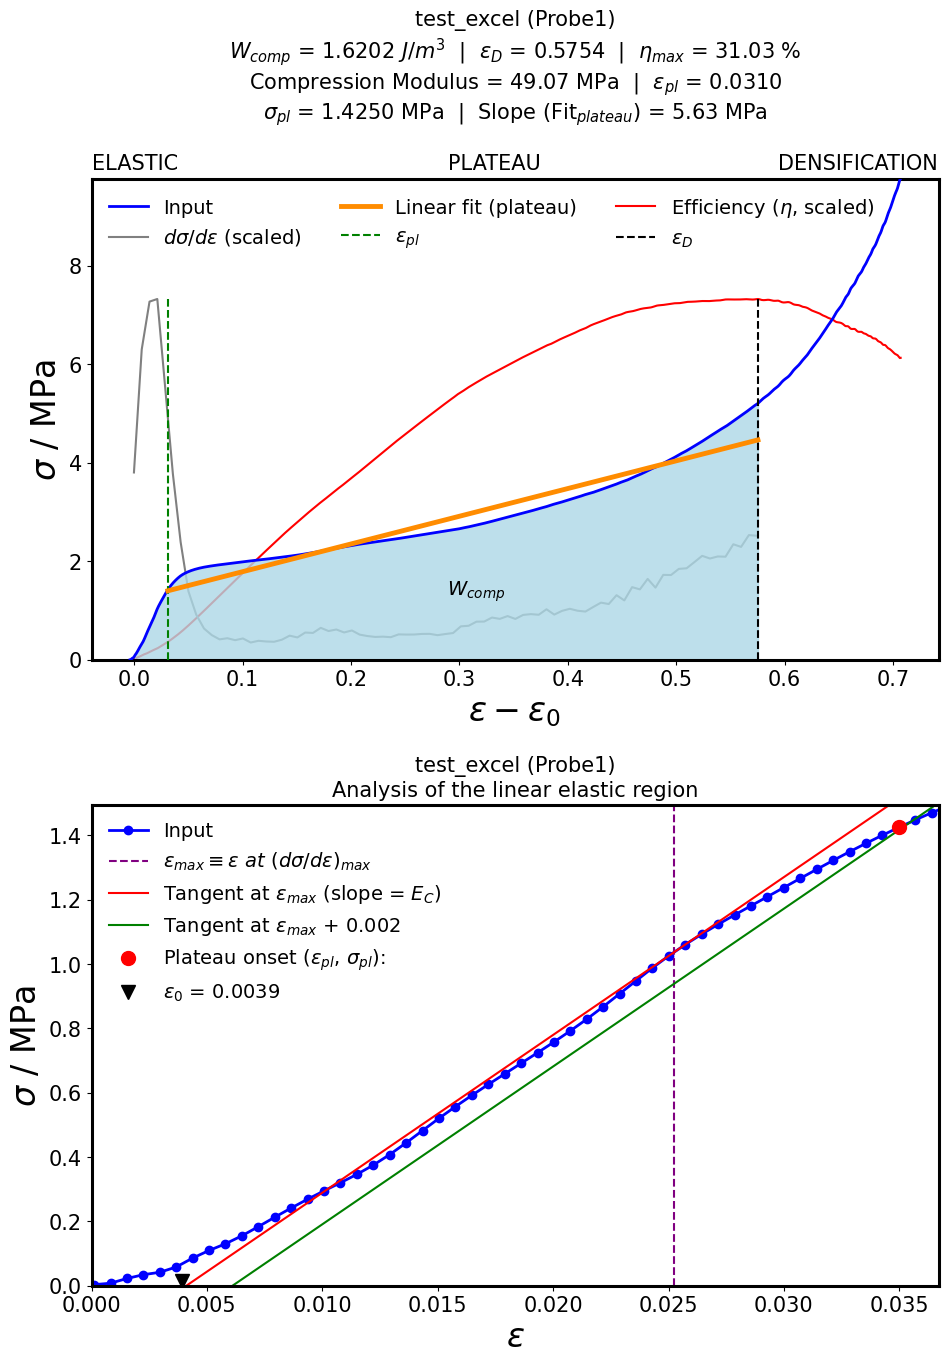

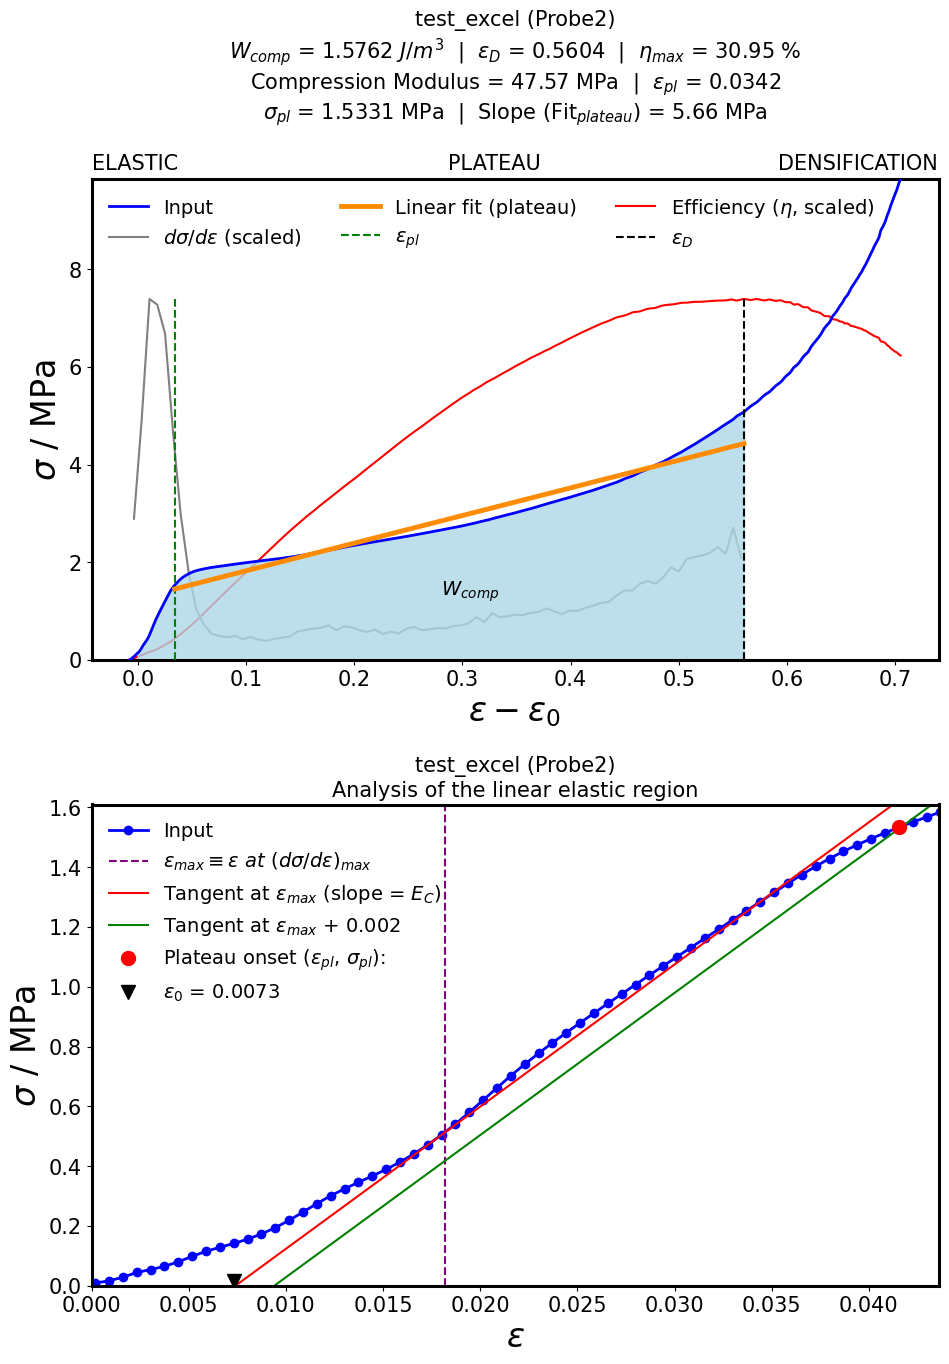

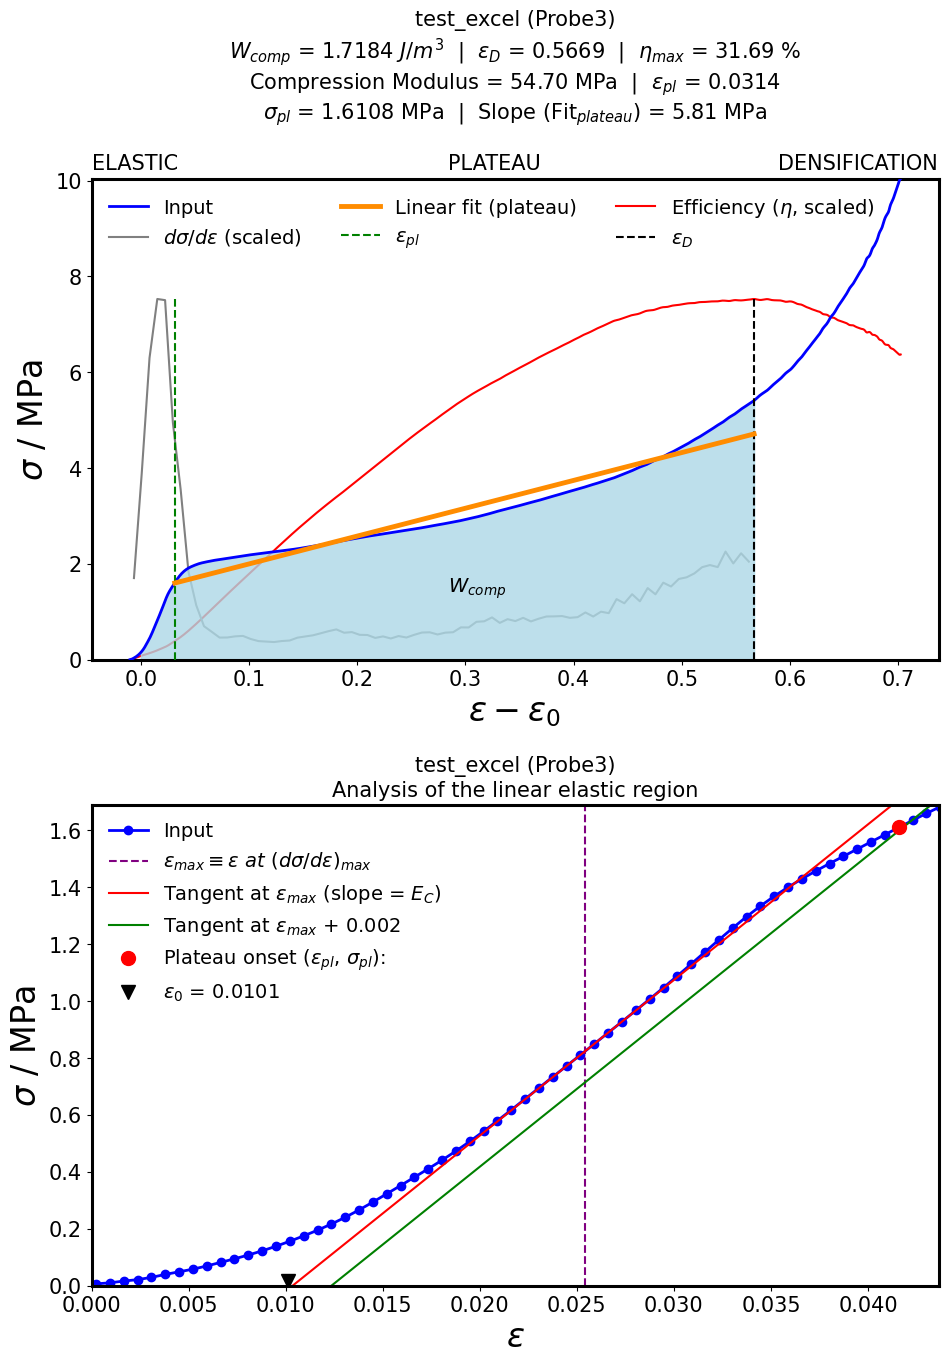

3 curves were treated and the
corresponding results were saved in the current directory.


In [15]:
############################################
############# YOUR INPUT HERE ##############

fileORfolder_name = "test_excel.xlsx" #EPP_Test_120C_error.xlsx" # Add here the file name or folder name
# tests available inside inputs.zip: test_excel.xls, test_ASCII.csv, test_ASCII.txt, folder_csv_files, folder_txt_files, folder_excel_files


# Add here the names of your worksheets (if the input is not an excel file, use any sheet name here!)
# sheet_names is a list of strings, like e.g. ['Sheet1', 'Sheet2', 'Sheet3']
# To get all available worksheets, use sheet_names = "all"
sheet_names = 'all'#['Probe 1'] # or to process all sheets, simply use sheet_names = 'all'


threshold_for_calculating_work = 'auto' # if 'auto', work of compression (W_comp) will be calculated up to the 
                                        # maximum efficiency (eta_max), otherwise, you can give a value 
                                        # (in epsilon units), integer or float (no string!), to determine the upper bound 
                                        # for the calculation of the area, i.e., for the calculation of W_comp.

lowerlimit_epsilon_pl = 'false' # if 'true', the epsilon_pl will be used to calculate the work of compression (W_comp)
                                # if 'false' (default), the work of compression is calculated from epsilon zero
            
show_plots_below = "yes" # use 'No' to save memory, in which case only results (as text) are printed below, 
                         # but all figures and generated output files are anyway saved. To visualize all figures
                         # below, just use 'Yes' instead (Figures/Files are always saved).

                        
############ DONT CHANGE THE LINE BELOW ! ############
main(fileORfolder_name, sheet_names, threshold_for_calculating_work, show_plots_below, tolerance)